<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/OwenHuelU2proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#install and import necessary libraries
!pip install preliz

#preliz, numpy, and arviz for visualizations and calculations
import preliz as pz
import numpy as np
import arviz as az

#pymc for the model
import pymc as pm

#**Unit 2 Project: LASA Ultimate O-Line Winning Percentage**
Ultimate Frisbee is a very popular sport at LASA. Last year, LASA went all the way to the national championship tournament, known as HSNI.

In order to win all of the games to get to nationals, LASA had to score a lot of points. Each point begins with one team on offense and the other on defense. In Ultimate, starting on offense is a massive advantage, as teams do not turn over the disc very often. Knowing you offensive success rate can allow you to move players between offense and defense to better your chances of winning. We call a score for the O-Line a score, and a loss for the O-Line a break, being broken.

This leads us to the question we will aim to answer: What will LASA's offensive (or O-line for short) winning percentage be this coming season?

([link to data for those curious](https://docs.google.com/spreadsheets/d/1XRWnCNbm2RFkbe8nwRIitQGfW93rBuwCuvlxt0XtIfQ/edit?usp=sharing))

##**Part 1: The Prior (and Other Optional Analytics)**

###**Prior Selection**
Many high school, and by extension LASA, Ultimate players play on club teams over the summer. These teams compete at many tournaments, but the most important one is known as Youth Club Championship or YCC. From playing in the tournament myself, I can conclude that the level of play of the top teams in the U17 Boys division is similar to that which LASA will face in Texas high school competition. The average age of this division is also similar to the average age of a high school player, so the players are generally of the same physicality and skill level. I was originally going to use the data from all of the YCC age and gender divisions, not just U17 boys, but that would have been a ton of data (way more than I needed), and also would not have been accurate to the skill level of Texas high school Ultimate, as the YCC teams in older divisions are significantly more skilled. I also limited the prior data to only the top 8 teams because more than that would have been way too much data (1000+ instances).

During the most recent YCC, the top 8 teams from the U17 Boys division scored 342 out of 486 O-line points collectively. We will use this data to inform our prior, for the reasons outlined above. 342 out of 486 turns out to be around 70%, which, based on my expertise, would be a reasonable guess if I had no data to base the prior on. I'm not extremely confident in this being the actual percentage though, so I will pick 21 and 9 for my alpha and beta values, which results in a 70% score rate as well.

We record the number of times a team on offense scores, 21 in this case, and how many times they get "broken" (lose the point), which is 9 in this case. Notably, we assume points are independent events; the result of one point does not affect anything about the conditions of the next.

The Beta distribution is used to determine the probability distribution for our prior.

<Axes: >

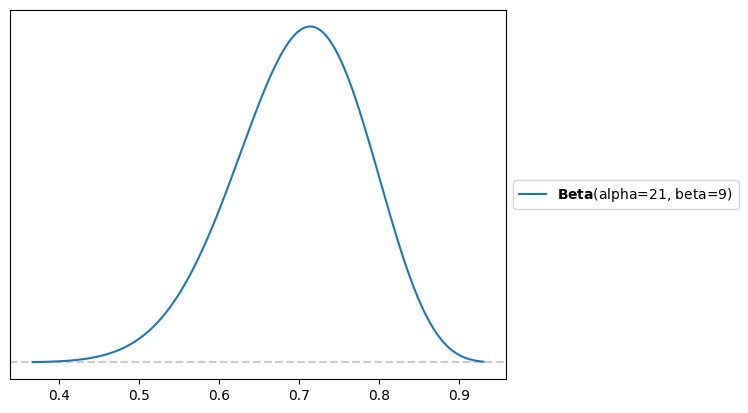

In [28]:
#plot of the beta distribution with alpha (scored) = 342 and beta (broken) = 144
pz.Beta(alpha=21,beta=9).plot_pdf()

Any probability under the curve is a valid guess, but I will choose the mean because that is the expected probability.

In [29]:
#store the prior distribution for the O-line percentage
Oline_prior = pz.Beta(alpha=21,beta=9)

Oline_prior.mean()

0.7

###**Likelihood Calculation (Analytical)**

In Texas competitions last season (spring league and state championship), LASA played a total of 55 O-line points and scored 41 of them. This data from the LASA team should be very similar to how we will perform in the future, as we have many of the same players on our team. Using the binomial distribution, we can calculate the likelihood of this data given $\theta$, our prior data.

We also played at two out of state tournaments, River Campus Classic and HSNI. I chose not to include data from these tournaments because a) the teams we played at these tournaments were significantly better than the teams we play in Texas, so it would have skewed the data towards more breaks than there shoud be, and b) we will likely not be playing at either of these tournaments this coming year, so they should not be included in the data to predict this coming year's scoring percentage. (I also had to watch our film manually to gather data because it wasn't already available, so it would have taken a very long time to gather data from these additional tournaments that aren't very reliable).

<Axes: >

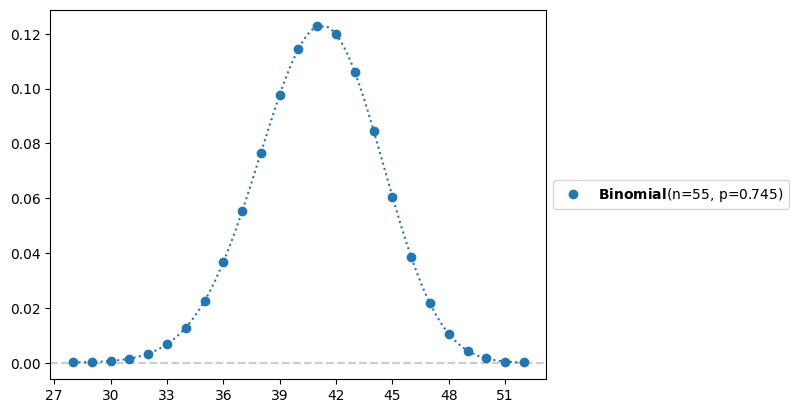

In [25]:
pz.Binomial(n = 55, p = 41/55).plot_pdf()

###**Posterior Calculation (Analytical)**

We know that $p(\theta | y) \propto p(\theta)p(y | \theta)$. We can therefore calculate the probability of the probability of O-Line scoring given the data we have.

In [17]:
#prior, or estimate gauged from YCC data
alpha_old = 21
beta_old = 9

#likelihood info, or data from LASA
k = 41 #scores
n = 55 #total O-Lines played

#mathematical formula
analytic_Oline = pz.Beta(alpha = alpha_old + k,beta = beta_old + n - k )

#O-Line's expected scoring %
analytic_Oline.mean()

0.7294117647058823

<Axes: >

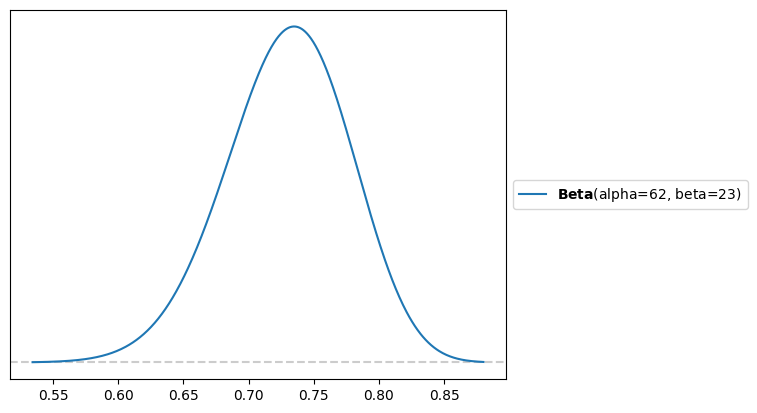

In [18]:
analytic_Oline.plot_pdf()

##**Part 2: The Pymc Model**
I selected the pymc Beta-binomial model to use because it is the only one I have used so far, and it works very well for binary data such as scoring or not scoring. I didn't have much trouble creating the model, as all of the code was taken from the Unit 2 Notes. I just had to change variable names and create some more comments, and it was good to go. In regards to the data given to the model, repeated here is the information from my likelihood:

In Texas competitions last season (spring league and state championship), LASA played a total of 55 O-line points and scored 41 of them. This data from the LASA team should be very similar to how we will perform in the future, as we have many of the same players on our team. Using the binomial distribution, we can calculate the likelihood of this data given $\theta$, our prior data.

We also played at two out of state tournaments, River Campus Classic and HSNI. I chose not to include data from these tournaments because a) the teams we played at these tournaments were significantly better than the teams we play in Texas, so it would have skewed the data towards more breaks than there shoud be, and b) we will likely not be playing at either of these tournaments this coming year, so they should not be included in the data to predict this coming year's scoring percentage. (I also had to watch our film manually to gather data because it wasn't already available, so it would have taken a very long time to gather data from these additional tournaments that aren't very reliable).

In [30]:
# Data from LASA's season, 41 scores and 14 breaks
Oline_data_24 = np.repeat([1,0], repeats = [41,14])

with pm.Model() as Oline_24_model:
  #prior (not exact data, but estimate) based on YCC data
  θ = pm.Beta('θ' , alpha = 21. , beta = 9.)

  # same likelihood, with our stand in for the binomial distribution but with
  # the updated data
  y = pm.Bernoulli('y', p = θ, observed = Oline_data_24)

  #sample from the posterior, 2000 for a more precise picture
  idata_Oline_24 = pm.sample(2000)

<Axes: title={'center': 'θ'}>

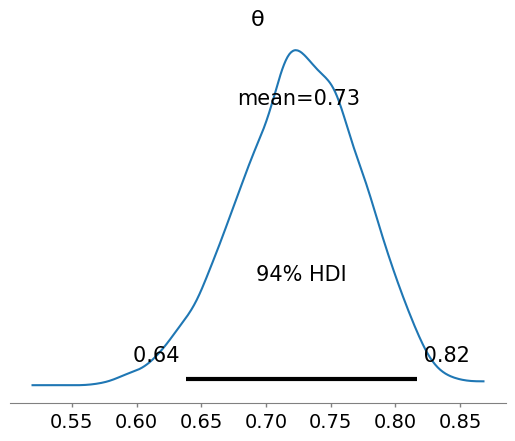

In [31]:
#vizualize the 2000 samples from the pymc model of the posterior
az.plot_posterior(idata_Oline_24)

In [32]:
#Generate the actual predictions for O-Line's next 2000 points
pm.sample_posterior_predictive(idata_Oline_24, model=Oline_24_model, extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [33]:
#stack the two MCMC chains together
stacked_Oline_24 = az.extract(idata_Oline_24, group="posterior_predictive")

#idata_Oline_24.posterior_predictive.y.to_series().values
stacked_Oline_24.sel(sample=0).sel(draw=0).y.to_series().values

#This generates the next 55 O-Line points and their outcomes

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

Looks like O-Line will not be scoring the first point they play of the season :(.

I will use the mean of our model in order to get the expected probability of O-Line scoring.

This gets us **73%** as our guess for O-Line's true probability of scoring.

##**Part 3: The Conclusion and Write-Up**
Our model concludes that $p(\theta | y) \approx 0.73$, or that LASA O-Line's chance of scoring is approximately **73%**.

<Axes: title={'center': 'θ'}>

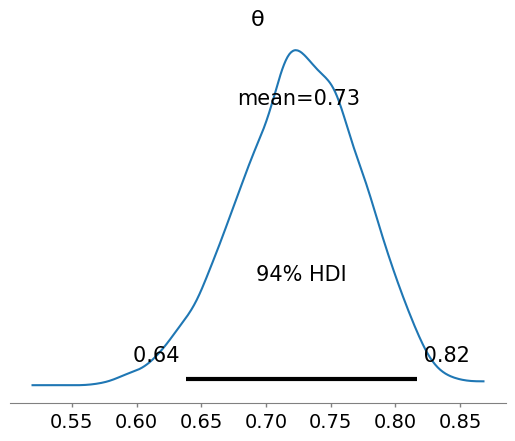

In [34]:
az.plot_posterior(idata_Oline_24)

This pdf represent our posterior, or all of our possible answers, the Beta-binomial distribution. The bell curve as a whole represents the cumulative probabilities and their respective probabilities, but if we want an exact answer rather than the entire spectrum, we can take the mean of this distribution, which turns out to be about **73%**.

This final result is pretty close to about what I predicted, just a little bit higher. The LASA team last year had a ton of seniors who were amazing players, so without them, I expect the percentage to go down a bit, which would explain why my prediction is lower than the model's resultant probability. I was not very surprised by this predicted probability from the model, as anything between 70 and 75% seems reasonable to me.

Something that I could change to improve the model is that defensive points have a significant impact on offensive points. Whenever you win a point in Ultimate, you start the next one on offensive. You also usually have designated players who play offense and defense respectively. Because of this, if your defense keeps losing every point, your offense will have to play more, meaning the same players are getting more and more tired. This isn't accounted for in the model, because we only look at offensive points independently. It would also probably be beneficial to separate data by games, as each game is against a different team with a different skill level.